In [1]:
from google.colab import drive , files
drive.mount('/content/drive')
import zipfile
import os
import numpy as np
import random


Mounted at /content/drive


In [2]:
zip_path = '/content/drive/MyDrive/dataset.zip'

# Directory where you want to extract the files
extract_path = '/content/'  # You can choose any folder inside /content

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

train_images_path = '/content/DataSet/train/images/'
train_labels_path = '/content/DataSet/train/labels/'

valid_images_path = '/content/DataSet/valid/images/'
valid_labels_path = '/content/DataSet/valid/labels/'

test_images_path = '/content/DataSet/test/images/'
test_labels_path = '/content/DataSet/test/labels/'

In [26]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Parameters
IMG_SIZE = (416, 416)  # Target image size
NUM_CLASSES = 15       # Number of classes

class SignDataGenerator(Sequence):
    def __init__(self, image_dir, label_dir, batch_size,augmentation=False):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.augmentation = augmentation
        # Verify valid pairs where the image exists
        self.image_files, self.label_files = self.filter_valid_pairs()

    def filter_valid_pairs(self):
      """Filter out label-image pairs where the image does not exist and shuffle the pairs."""
      valid_image_files = []
      valid_label_files = []

      label_files = [f for f in os.listdir(self.label_dir) if f.endswith('.txt')]
      for label_file in label_files:
          image_file = label_file.replace('.txt', '.jpg')  # Match image name
          image_path = os.path.join(self.image_dir, image_file)
          if os.path.exists(image_path):  # Check if the image exists
              valid_image_files.append(image_file)
              valid_label_files.append(label_file)
          else:
              print(f"Image not found for label: {label_file}")  # Log missing image

      # Shuffle both lists while maintaining correspondence
      #paired_files = list(zip(valid_image_files, valid_label_files))
      #random.shuffle(paired_files)  # Shuffle the list of tuples
      #valid_image_files, valid_label_files = zip(*paired_files)  # Unzip back into two lists

      return valid_image_files, valid_label_files

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def parse_label(self, label_path):
        bounding_boxes = []
        with open(label_path, 'r') as f:
            lines = f.readlines()  # Read all lines in the label file

        for line in lines:
            parts = line.strip().split()  # Split line into parts
            if parts:
                class_id = int(parts[0])  # The class ID is the first element
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                bounding_boxes.append((class_id, x_center, y_center, width, height))
            #else:
             #   class_id = 0  # Default to 0 if line is empty

        return bounding_boxes

    def crop_image(self, image, bounding_boxes):
      cropped_images = []
      img_width, img_height = image.size

      for class_id, x_center, y_center, width, height in bounding_boxes:
          # Convert normalized values to pixel values
          x_min = int((x_center - width / 2) * img_width)
          y_min = int((y_center - height / 2) * img_height)
          x_max = int((x_center + width / 2) * img_width)
          y_max = int((y_center + height / 2) * img_height)

          # Crop the image (always done)
          cropped_image = image.crop((x_min, y_min, x_max, y_max))
          cropped_image = cropped_image.resize(IMG_SIZE)  # Resize to fixed IMG_SIZE
          cropped_images.append(img_to_array(cropped_image) / 255.0)  # Normalize pixel values

          if self.augmentation:
              # If augmentation is enabled, rotate the cropped image and append it
              for angle in [30,60,90,120, 180, 270]:  # Rotate 90, 180, 270 degrees
                  rotated_image = cropped_image.rotate(angle)
                  cropped_images.append(img_to_array(rotated_image) / 255.0)  # Append rotated image

      return np.array(cropped_images)


    def get_all_labels(self):
        all_labels = []
        for image_file in self.image_files:
            label_file = image_file.replace('.jpg', '.txt')
            label_path = os.path.join(self.label_dir, label_file)
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        class_id = int(line.split()[0])
                        all_labels.append(class_id)
        return np.array(all_labels)


    def __getitem__(self, index):
        # Get batch indices
        batch_images = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.label_files[index * self.batch_size:(index + 1) * self.batch_size]

        # Load data
        images = []
        labels = []
        for img_name, label_name in zip(batch_images, batch_labels):
            # Load and preprocess the image
            img_path = os.path.join(self.image_dir, img_name)
            image = load_img(img_path)


            # Parse the label and get bounding box coordinates
            label_path = os.path.join(self.label_dir, label_name)
            bounding_boxes = self.parse_label(label_path)

            # Crop the image based on the bounding boxes
            cropped_images = self.crop_image(image, bounding_boxes)
            images.extend(cropped_images)  # Add cropped images to the list

            # Create one-hot labels for each cropped image
            for class_id, _, _, _, _ in bounding_boxes:
                label_one_hot = np.zeros(NUM_CLASSES)  # Create a zero vector of length NUM_CLASSES
                label_one_hot[class_id] = 1  # Set the index corresponding to the class_id to 1
                labels.append(label_one_hot)

        return np.array(images), np.array(labels)

# Instantiate data generators
train_gen = SignDataGenerator(train_images_path, train_labels_path, batch_size=45)
valid_gen = SignDataGenerator(valid_images_path, valid_labels_path, batch_size=45)
test_gen = SignDataGenerator(test_images_path, test_labels_path, batch_size=45)


Image not found for label: 00005_00013_00015_png.rf.6ae60e5720c831d5d379be9a78fa4fd4(1).txt
Image not found for label: 00005_00019_00009_png.rf.cfa43b110d8e5f5e9ccdc168e25e2998(1).txt
Image not found for label: 00005_00013_00016_png.rf.104423a2b5146af20e0913bbedcf05f6(1).txt
Image not found for label: 00005_00012_00013_png.rf.3f1b741ddfcf506c5ca1081b2f689bec(1).txt
Image not found for label: 00005_00013_00023_png.rf.597dabfb0a8be9b9e55a5fd4d741de99(1).txt
Image not found for label: 00005_00013_00006_png.rf.2d3ce825b022deea4149ee37d13b5a37(1).txt
Image not found for label: 00005_00018_00020_png.rf.0aaffe7da00f33f27787dea1c8aadf65(1).txt
Image not found for label: 00005_00021_00012_png.rf.af43b9c896df20dc00000269467de21f(1).txt
Image not found for label: 00005_00019_00023_png.rf.3fa9a988aa0486f9328a462f6537d46f(1).txt
Image not found for label: 00005_00021_00009_png.rf.e0b3255808fa828ed6cd0a717883486d(1).txt


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Define the CNN model
model = Sequential([
    # First convolutional block
    Conv2D(16, (3, 3), padding="same", input_shape=(90, 90, 3), activation='relu'),
    MaxPool2D((2, 2), padding="same"),

    # Second convolutional block
    Conv2D(32, (3, 3), padding="same", activation='relu'),
    MaxPool2D((2, 2), padding="same"),

    # Third convolutional block
    Conv2D(64, (5, 5), padding="same", activation='relu'),
    MaxPool2D((2, 2), padding="same"),

    # Fourth convolutional block
    Conv2D(128, (7, 7), padding="same", activation='relu'),
    MaxPool2D((2, 2), padding="same"),

    # Flatten and fully connected layers
    Flatten(),
    Dense(232, activation='relu'),

    Dense(116, activation='relu'),
    Dense(15, activation='softmax')
])
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 23, 23, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 232)                 │       1,069,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 116)                 │          27,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 15)                  │           1,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,195,511 (4.56 MB)

 Trainable params: 1,195,511 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,                         # Training data generator
    validation_data=valid_gen,         # Validation data generator
    epochs=10,                         # Number of epochs
    verbose=1 ,
    shuffle=True,
    batch_size =45,
  #  callbacks=[reduce_lr]

)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 974ms/step - accuracy: 0.2449 - loss: 2.3707 - val_accuracy: 0.4354 - val_loss: 1.6537
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.4458 - loss: 1.6487 - val_accuracy: 0.5021 - val_loss: 1.4559
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.5230 - loss: 1.4219 - val_accuracy: 0.7362 - val_loss: 0.8714
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7497 - loss: 0.7651 - val_accuracy: 0.8347 - val_loss: 0.5143
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8571 - loss: 0.4449 - val_accuracy: 0.8835 - val_loss: 0.3633
Epoch 6/10
47/79 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8904 - loss: 0.3388

In [7]:
model.save('aug.h5')

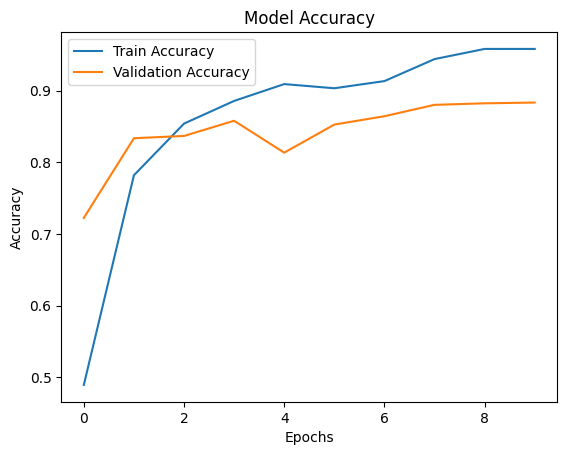

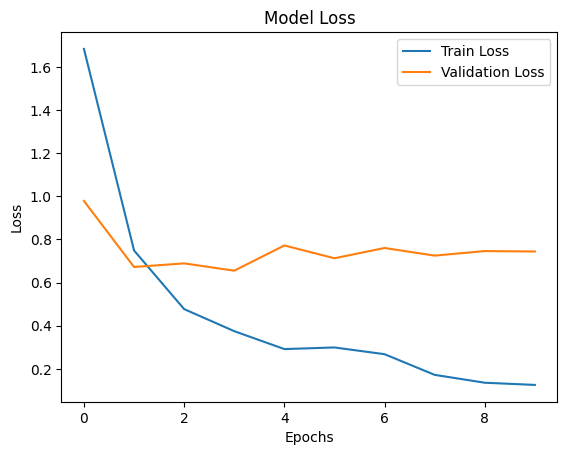

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(valid_gen, verbose=1)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.8969 - loss: 0.3854
Validation Loss: 0.3512241840362549
Validation Accuracy: 0.9088982939720154


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 799ms/step
Accuracy :  0.8402597402597403


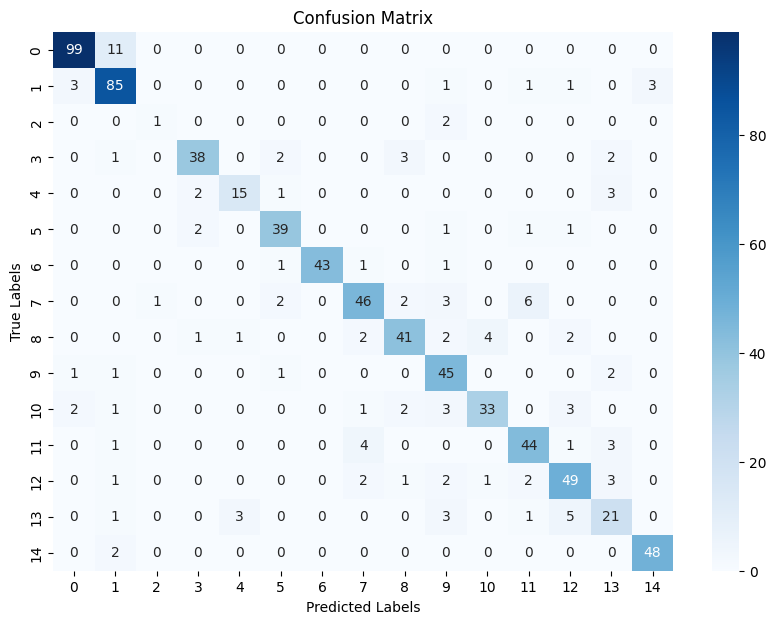

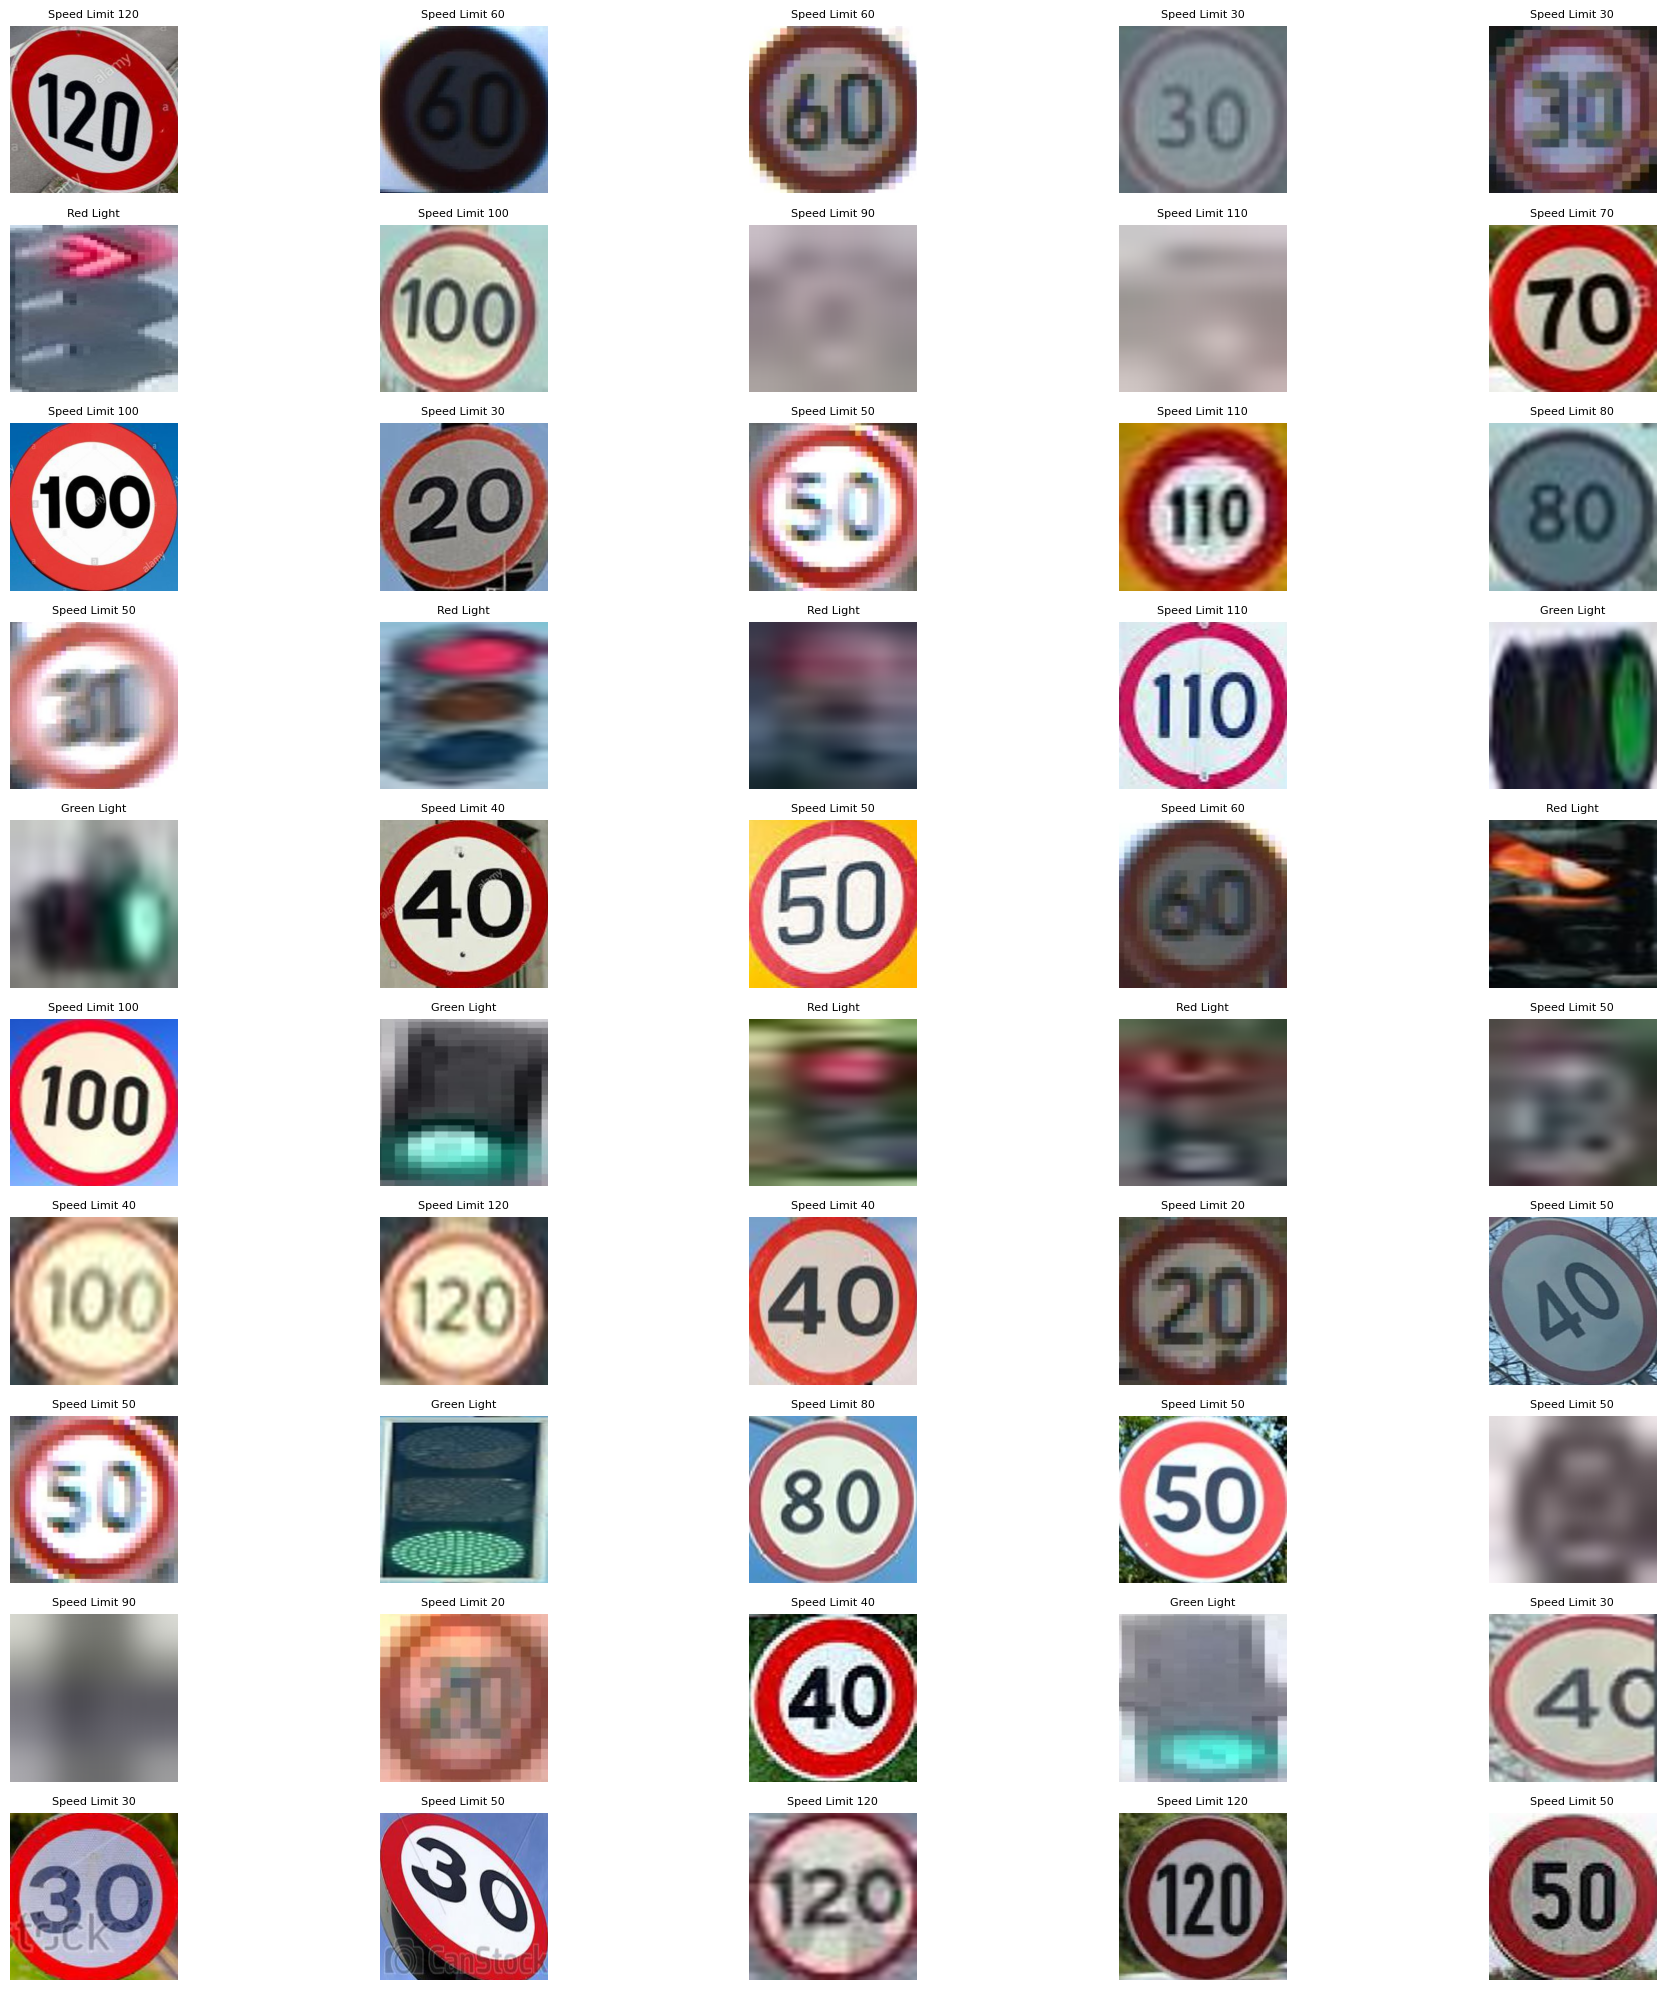

In [21]:
from sklearn.metrics import confusion_matrix , accuracy_score
import seaborn as sns
import numpy as np

# Class names
names = [
    'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110',
    'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40',
    'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80',
    'Speed Limit 90', 'Stop'
]

all_test_labels = test_gen.get_all_labels()

# Predict the labels on the test data
test_predictions = model.predict(test_gen, verbose=1)

# Convert predictions from probabilities to class labels
predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(all_test_labels, predictions)

accuracy= accuracy_score(all_test_labels,predictions)
print("Accuracy : ", accuracy)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_test_labels), yticklabels=np.unique(all_test_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Map class IDs to names
predicted_class_names = [names[class_id] for class_id in predictions]

# Function to visualize images with predictions
def visualize_predictions(generator, predicted_names, num_images=50):
    images, _ = generator[0]  # Get the first batch of images
    plt.figure(figsize=(20, 20))  # Adjust the figure size for a larger grid
    for i in range(min(num_images, len(images))):
        plt.subplot(10, 5, i + 1)  # Display in a 10x5 grid
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(predicted_names[i], fontsize=8)
    plt.tight_layout()
    plt.show()

# Visualize the first 50 images and their predicted labels
visualize_predictions(test_gen, predicted_class_names, num_images=50)

In [16]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 20.0 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model1 = YOLO('yolov8n.pt')
model1.train(
    data='/content/DataSet/data.yaml',
    epochs=30,  # Number of training epochs
    batch=32,   # Batch size
    imgsz=416,  # Image size
    optimizer='auto'  # Optimizer
)


Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/DataSet/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

train: Scanning /content/DataSet/train/labels.cache... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/DataSet/valid/labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       2.8G     0.8276      3.257      1.086         15        416: 100%|██████████| 111/111 [00:39<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.35it/s]

                   all        801        944      0.218      0.467      0.207      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.13G      0.717        2.2      1.016         23        416: 100%|██████████| 111/111 [00:36<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.21it/s]

                   all        801        944      0.296      0.507      0.356      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.14G     0.7069       1.92     0.9953         16        416: 100%|██████████| 111/111 [00:33<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


                   all        801        944       0.36      0.532       0.43       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.12G      0.699      1.665     0.9922         19        416: 100%|██████████| 111/111 [00:34<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


                   all        801        944      0.538      0.606      0.583      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.13G     0.6827      1.454      0.979         23        416: 100%|██████████| 111/111 [00:38<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


                   all        801        944       0.75      0.609      0.689      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.13G      0.663      1.323     0.9743         33        416: 100%|██████████| 111/111 [00:35<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


                   all        801        944      0.733      0.666      0.746      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.14G     0.6427      1.207     0.9589         22        416: 100%|██████████| 111/111 [00:36<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

                   all        801        944      0.709      0.709      0.749      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.12G     0.6386      1.116     0.9575         24        416: 100%|██████████| 111/111 [00:34<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]

                   all        801        944      0.837      0.726      0.806      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.12G     0.6274      1.063     0.9574         24        416: 100%|██████████| 111/111 [00:33<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


                   all        801        944      0.885      0.742      0.828      0.713

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.12G     0.6111     0.9988     0.9481         21        416: 100%|██████████| 111/111 [00:35<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


                   all        801        944      0.864      0.738      0.827      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.13G     0.6089     0.9678     0.9459         23        416: 100%|██████████| 111/111 [00:36<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

                   all        801        944       0.89       0.77       0.85      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.13G     0.6036     0.9362     0.9441         33        416: 100%|██████████| 111/111 [00:37<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

                   all        801        944      0.886        0.8      0.864      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.13G     0.5962     0.8704     0.9394         24        416: 100%|██████████| 111/111 [00:35<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]

                   all        801        944      0.925      0.784      0.871      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.13G     0.5741     0.8516     0.9349         18        416: 100%|██████████| 111/111 [00:33<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


                   all        801        944      0.894      0.782      0.863      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.14G     0.5782     0.8268     0.9406         22        416: 100%|██████████| 111/111 [00:34<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


                   all        801        944      0.908      0.789      0.862      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.13G     0.5674     0.8003     0.9352         23        416: 100%|██████████| 111/111 [00:36<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


                   all        801        944      0.929      0.803      0.881      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.13G     0.5704     0.7782     0.9365         21        416: 100%|██████████| 111/111 [00:35<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


                   all        801        944       0.91      0.804      0.888      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.12G     0.5626     0.7777     0.9285         19        416: 100%|██████████| 111/111 [00:36<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]


                   all        801        944      0.929      0.809      0.886      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.13G     0.5526     0.7342     0.9242         26        416: 100%|██████████| 111/111 [00:35<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]

                   all        801        944      0.901      0.834      0.899      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.13G     0.5438     0.7015     0.9238         19        416: 100%|██████████| 111/111 [00:35<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]

                   all        801        944      0.945      0.815      0.899      0.775


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.12G      0.534     0.4976     0.8749         11        416: 100%|██████████| 111/111 [00:33<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]

                   all        801        944      0.916      0.823      0.892      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.14G     0.5272     0.4888     0.8747         19        416: 100%|██████████| 111/111 [00:31<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


                   all        801        944      0.927      0.818      0.897      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.12G     0.5178     0.4492     0.8704         10        416: 100%|██████████| 111/111 [00:31<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


                   all        801        944      0.954      0.835      0.911      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.13G     0.5168     0.4349     0.8672         10        416: 100%|██████████| 111/111 [00:32<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]

                   all        801        944      0.948       0.84      0.914       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.14G     0.5129     0.4238     0.8705         12        416: 100%|██████████| 111/111 [00:32<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


                   all        801        944      0.934      0.848      0.913      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.13G     0.4988     0.4078     0.8602         10        416: 100%|██████████| 111/111 [00:33<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.63it/s]

                   all        801        944      0.938      0.853      0.919      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.12G     0.4919     0.3936     0.8631         14        416: 100%|██████████| 111/111 [00:33<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


                   all        801        944      0.953      0.837       0.92      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.11G     0.4855     0.3782     0.8586         10        416: 100%|██████████| 111/111 [00:35<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


                   all        801        944      0.942      0.851      0.918      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.14G     0.4765     0.3746     0.8565         12        416: 100%|██████████| 111/111 [00:34<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


                   all        801        944      0.948      0.865      0.926      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.11G      0.475     0.3653     0.8598         13        416: 100%|██████████| 111/111 [00:35<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


                   all        801        944      0.954      0.855      0.925      0.808

30 epochs completed in 0.340 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]


                   all        801        944      0.954      0.856      0.925      0.808
           Green Light         87        122      0.843      0.615      0.717      0.418
             Red Light         74        108      0.885      0.571      0.716      0.442
       Speed Limit 100         52         52      0.962      0.942      0.979      0.905
       Speed Limit 110         17         17      0.941      0.882      0.968      0.885
       Speed Limit 120         60         60          1      0.932      0.992      0.913
        Speed Limit 20         56         56          1      0.937      0.983      0.887
        Speed Limit 30         71         74      0.982      0.946      0.974      0.916
        Speed Limit 40         53         55      0.963      0.909      0.981      0.877
        Speed Limit 50         68         71          1       0.83       0.94      0.834
        Speed Limit 60         76         76      0.945      0.903      0.945      0.864
        Speed Limit 7

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78968422f7c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [ ]:
model.save("cnn_validaugementation.h5")


image 1/1 /content/ttjpg.jpg: 416x416 1 Speed Limit 40, 7.2ms
Speed: 5.8ms preprocess, 7.2ms inference, 832.5ms postprocess per image at shape (1, 3, 416, 416)
1


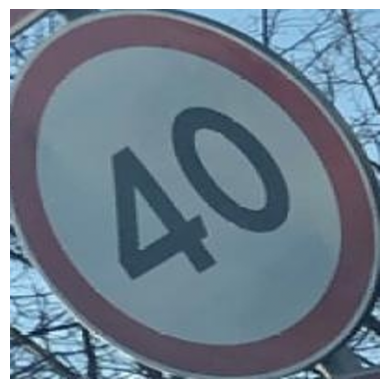

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
[[ 7.8888e-10  2.8211e-09  1.1959e-07  0.00037831  2.4721e-08  1.7471e-05  5.2117e-08  0.00010186    0.051003      0.0713     0.16058    6.29e-05     0.71655  1.1396e-06  1.4693e-06]]
Résultat pour l'image 1 : Speed Limit 80


In [19]:
from ultralytics import YOLO
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
image_dir = '/content/'

image_path = os.path.join(image_dir, "ttjpg.jpg")

panel_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
names = [
    'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110',
    'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40',
    'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80',
    'Speed Limit 90', 'Stop'
]


yolo_model_path = "/content/bestmoretrainning.pt"
model_yolo = YOLO(yolo_model_path)

results = model_yolo.predict(image_path)
cropped_images = []
# Extraire les informations pour chaque détection
for result in results:
    for detection in result.boxes.data:
        x_min, y_min, x_max, y_max, score, class_id = detection.tolist()


# Recadrer l'image
        image = load_img(image_path)
        cropped_image = image.crop((x_min, y_min, x_max, y_max))
        cropped_image = cropped_image.resize((416,416))  # Redimensionner
        cropped_images.append(np.array(cropped_image) / 255.0)  # Normaliser les pixels
print(len(cropped_images))
# Afficher les images recadrées
for i, cropped in enumerate(cropped_images):
    plt.subplot(1, len(cropped_images), i + 1)
    plt.imshow(cropped)
    plt.axis('off')
plt.show()
# Effectuer une prédiction sur les images recadrées
for i, cropped in enumerate(cropped_images):
    cropped_image = np.expand_dims(cropped, axis=0)  # Ajouter une dimension batch
    resultat = model.predict(cropped_image)  # Prédiction sur une image
    print(resultat)
    predicted_class_index = np.argmax(resultat)
    # Map the predicted class index to class name
    predicted_class_name = names[predicted_class_index]
    print(f"Résultat pour l'image {i + 1} :", predicted_class_name)


In [ ]:
model1.save("")